In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset,Dataset
import torchvision
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
import copy
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
all_trans = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 0.8), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
trainset = torchvision.datasets.STL10(root='./stl10/train',download=True,split='test',transform=all_trans)
augmented_dataset = copy.deepcopy(trainset)
augmented_dataset.transform = train_transform
aug_trainset = torch.utils.data.ConcatDataset([trainset, augmented_dataset])
testset = torchvision.datasets.STL10(root='./stl10/test',download=True,split='train',transform=all_trans)

100%|██████████| 2.64G/2.64G [04:30<00:00, 9.77MB/s] 


Extracting ./stl10/train/stl10_binary.tar.gz to ./stl10/train


100%|██████████| 2.64G/2.64G [04:46<00:00, 9.21MB/s] 


Extracting ./stl10/test/stl10_binary.tar.gz to ./stl10/test


In [6]:
train_loader = DataLoader(aug_trainset,batch_size=32,shuffle=True)
test_loader = DataLoader(testset,batch_size=32)

In [7]:
labels = {}
for img,lab in aug_trainset:
    if lab in labels:
        labels[lab] += 1
    else:
        labels[lab] = 1

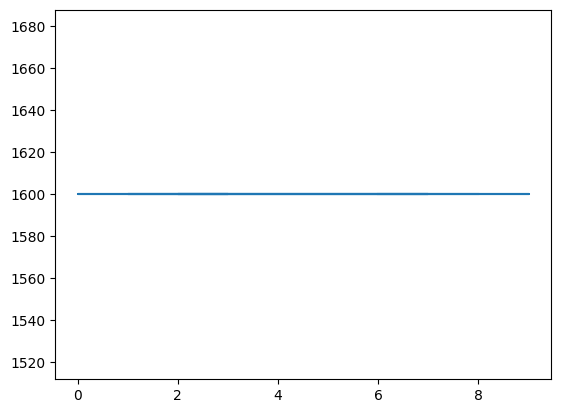

In [8]:
plt.plot(list(labels.keys()),list(labels.values()));

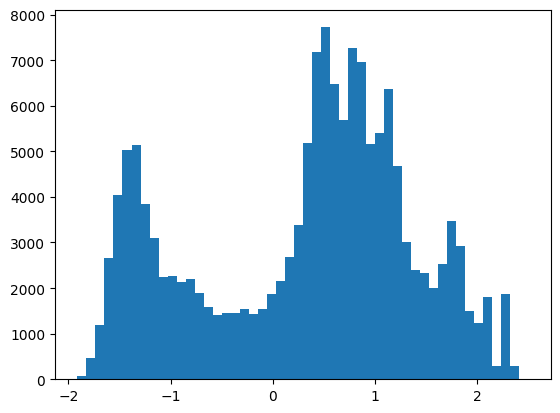

In [9]:
plt.hist(aug_trainset[0][0].flatten(),50);

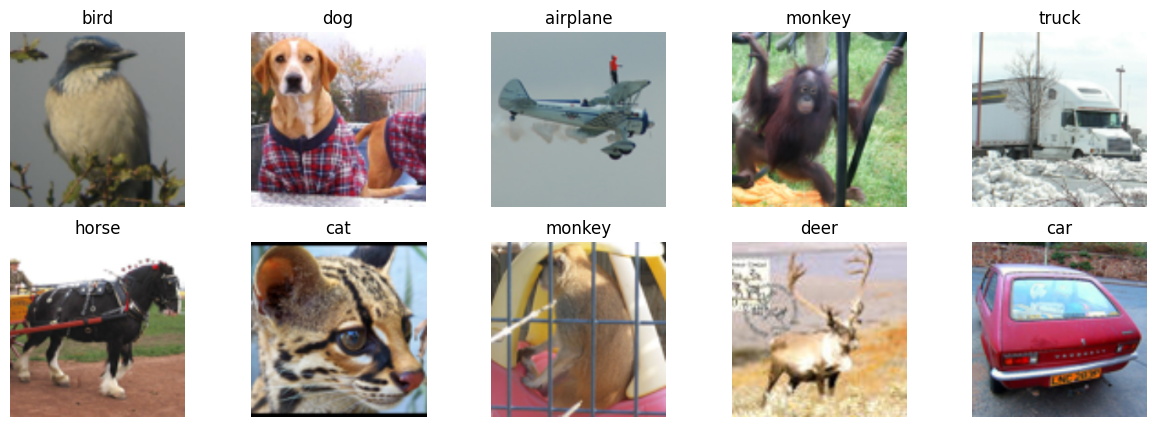

In [10]:
def denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for axis in ax.flatten():
    r = np.random.randint(0, len(trainset))
    img, label = aug_trainset[r]

    img = denormalize(img)
    img = torch.clamp(img, 0, 1)

    axis.imshow(img.permute(1, 2, 0))
    axis.set_title(trainset.classes[label])
    axis.axis('off')

In [11]:
from torchvision.models import resnet34, ResNet34_Weights
resnet = resnet34(weights=ResNet34_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 219MB/s]


In [12]:
# changing the last layer to output 10 classes
resnet.fc = nn.Sequential(
    nn.Linear(512, 10)
)
# # Freezing all layers except the last one
# for p in alexnet.parameters():
#     p.requires_grad = False
# for p in alexnet.fc.parameters():
#     p.requires_grad = True

In [13]:
resnet = resnet.to(device)
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(),momentum=0.9,lr=0.001,weight_decay=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [14]:
from torchsummary import summary
summary(resnet,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [15]:
from tqdm import tqdm

best_val_acc = 0

for epoch in range(epochs):
    resnet.train()
    correct_train = 0
    total_train = 0
    total_loss = 0
    num_batches = 0

    for img, lab in tqdm(train_loader, f'epoch: {epoch+1}/{epochs}'):
        img, lab = img.to(device), lab.to(device)
        y_hat = resnet(img)
        loss = criterion(y_hat, lab)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(resnet.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        correct_train += (torch.argmax(y_hat, axis=1) == lab).sum().item()
        total_train += lab.size(0)

    avg_train_acc = (correct_train / total_train) * 100
    avg_train_loss = total_loss / num_batches
    print(f'Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.2f}%')

    resnet.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for img, lab in test_loader:
            img, lab = img.to(device), lab.to(device)
            y_hat = resnet(img)
            correct_test += (torch.argmax(y_hat, axis=1) == lab).sum().item()
            total_test += lab.size(0)

    avg_test_acc = (correct_test / total_test) * 100
    print(f'Validation Accuracy: {avg_test_acc:.2f}%\n')

    if avg_test_acc > best_val_acc:
        best_val_acc = avg_test_acc
        torch.save(resnet.state_dict(), "best_model.pth")
        print(f'Best model saved with Validation Accuracy: {best_val_acc:.2f}%\n')

    scheduler.step(best_val_acc)

epoch: 1/10: 100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Train Loss: 0.9619 | Train Accuracy: 75.28%
Validation Accuracy: 95.72%

Best model saved with Validation Accuracy: 95.72%



epoch: 2/10: 100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


Train Loss: 0.2465 | Train Accuracy: 93.71%
Validation Accuracy: 96.90%

Best model saved with Validation Accuracy: 96.90%



epoch: 3/10: 100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


Train Loss: 0.1730 | Train Accuracy: 95.14%
Validation Accuracy: 97.22%

Best model saved with Validation Accuracy: 97.22%



epoch: 4/10: 100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Train Loss: 0.1331 | Train Accuracy: 96.11%
Validation Accuracy: 97.42%

Best model saved with Validation Accuracy: 97.42%



epoch: 5/10: 100%|██████████| 500/500 [02:02<00:00,  4.10it/s]


Train Loss: 0.1112 | Train Accuracy: 96.84%
Validation Accuracy: 97.46%

Best model saved with Validation Accuracy: 97.46%



epoch: 6/10: 100%|██████████| 500/500 [02:02<00:00,  4.07it/s]


Train Loss: 0.0936 | Train Accuracy: 97.53%
Validation Accuracy: 97.70%

Best model saved with Validation Accuracy: 97.70%



epoch: 7/10: 100%|██████████| 500/500 [02:01<00:00,  4.11it/s]


Train Loss: 0.0803 | Train Accuracy: 97.74%
Validation Accuracy: 97.70%



epoch: 8/10: 100%|██████████| 500/500 [02:03<00:00,  4.05it/s]


Train Loss: 0.0699 | Train Accuracy: 98.14%
Validation Accuracy: 97.62%



epoch: 9/10: 100%|██████████| 500/500 [02:03<00:00,  4.06it/s]


Train Loss: 0.0592 | Train Accuracy: 98.44%
Validation Accuracy: 97.84%

Best model saved with Validation Accuracy: 97.84%



epoch: 10/10: 100%|██████████| 500/500 [02:04<00:00,  4.03it/s]


Train Loss: 0.0550 | Train Accuracy: 98.61%
Validation Accuracy: 97.70%



**Testing The Model**

<ipython-input-18-d673cb7f31bf>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path, map_location=torch.device("cpu")))


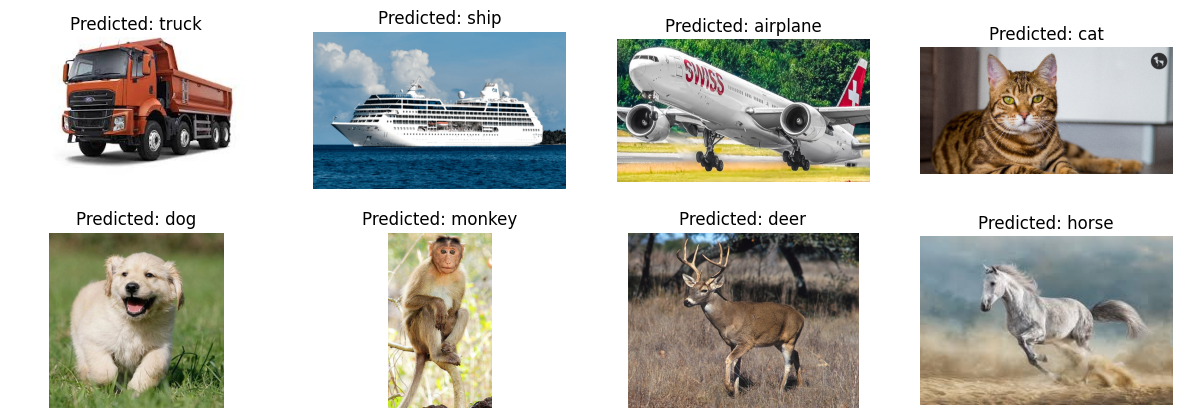

In [18]:
import imageio.v3 as iio
from PIL import Image
import requests

best_model = resnet34(weights=None)
best_model.fc = nn.Sequential(
    nn.Linear(512, 10)
)

best_model_path = "/kaggle/working/best_model.pth"
best_model.load_state_dict(torch.load(best_model_path, map_location=torch.device("cpu")))
best_model.eval()

truck = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQYD5UL1GXpvNSYNEcIHC5--qpwVN6MolRg8A&s"
ship = "https://www.marineinsight.com/wp-content/uploads/2019/08/Cruise-ships-1.png"
aero = "https://i.ytimg.com/vi/3JQNMG2VhDM/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLBa9lXMoMO8D2hb51kMbabozIx3tQ"
cat = "https://cdn.shopify.com/s/files/1/0086/0795/7054/files/Bengal_Cat.jpg?v=1722406738"
dog = "https://www.akc.org/wp-content/uploads/2015/03/so-you-want-to-breed-dogs-500x500.jpg"
monkey = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Bonnet_macaque_%28Macaca_radiata%29_Photograph_By_Shantanu_Kuveskar.jpg/220px-Bonnet_macaque_%28Macaca_radiata%29_Photograph_By_Shantanu_Kuveskar.jpg"
deer = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/White-tailed_deer.jpg/640px-White-tailed_deer.jpg"
horse = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTWjlzjTkieBVN-tV9IeLLBUtRMhSz07SAS6Q&s"
img_list = [truck,ship,aero,cat,dog,monkey,deer,horse]

fig,ax = plt.subplots(2,4,figsize=(15,5))
for i,ax in enumerate(ax.flatten()):
  image = Image.open(requests.get(img_list[i], stream=True).raw).convert('RGB')
  t_img = all_trans(image)
  t_img = t_img.unsqueeze(0)
  t_img = t_img.to(torch.device("cpu"))
  pred = best_model(t_img)
  pred = torch.argmax(pred, axis=1)
  ax.imshow(image)
  ax.set_title(f'Predicted: {trainset.classes[pred.item()]}');
  ax.axis('off');
